# Analysis of the 3 Corpora

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from dash import Dash, dcc, html, dash_table
from dash.dash_table.Format import Group

from src.preprocessing import generate_df_codes
from src.visualization import plot_code_distribution

def report_corpus(corpus, show=True, debug=False):
    DATA = f'data/processed/{corpus}.tsv'
    DATA_VAR = 'data/variables/processed/variables.tsv'

    print(f"Loading data from {DATA}")
    df_data = pd.read_csv(DATA, sep='\t', dtype={'code': str})
    df_var = pd.read_csv(DATA_VAR, sep='\t', dtype={'code': str})

    df_code_ovr = generate_df_codes(df_data=df_data, df_vars=df_var, debug=debug)

    output = plot_code_distribution(df_code_ovr, corpus=corpus, show=show)
    return df_code_ovr, output

ls_corpora = ["distemist", "symptemist", "medprocner"]

df_report = pd.DataFrame()
ls_figures = []
for corpus in ls_corpora:
    _, output = report_corpus(corpus, show=False)
    df_report_i = output[0]
    figures = output[1:]
    df_report_i["corpus"] = corpus
    df_report = pd.concat([df_report, df_report_i])

    ls_figures.extend(figures)

# show the count_ID, total_mentions and total_ratio for each corpus using ID as index
df_out = df_report.pivot(index=["ID", "name", "term"], columns="corpus", values=["count_ID", "total_mentions", "total_ratio"])
df_out.columns = [f"{col}_{sub}" for col, sub in df_out.columns]
df_out = df_out.reset_index()


# Initialize the Dash app
app = Dash(__name__)
# Define the Dash layout with interactive plots and table
app.layout = html.Div([
    html.H1("Interactive Data Report"),

        *[dcc.Graph(figure=fig) for fig in ls_figures],

    dash_table.DataTable(
        id='datatable-interactivity',
        columns=[{"name": i, "id": i} for i in df_out.columns],
        data=df_out.to_dict('records'),
        filter_action="native",
        sort_action="native",
        sort_mode="multi",
        column_selectable="single",
        row_selectable="multi",
        selected_columns=[],
        selected_rows=[],
        page_action="native",
        page_current=0,
        page_size=20,
    ),
])


app.run_server(port=8001)

Loading data from data/processed/distemist.tsv
Loading data from data/processed/symptemist.tsv
Loading data from data/processed/medprocner.tsv


In [6]:
# show the count_ID, total_mentions and total_ratio for each corpus using ID as index
df_out = df_report.pivot(index=["ID", "name", "term"], columns="corpus", values=["count_ID", "total_mentions", "total_ratio"])
df_out.columns = [f"{col}_{sub}" for col, sub in df_out.columns]
df_out = df_out.reset_index()

In [7]:
print(df_out.to_markdown())

|     | ID             | name                                                                                                | term                                                                                                                              |   count_ID_distemist |   count_ID_medprocner |   count_ID_symptemist |   total_mentions_distemist |   total_mentions_medprocner |   total_mentions_symptemist |   total_ratio_distemist |   total_ratio_medprocner |   total_ratio_symptemist |
|----:|:---------------|:----------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------|---------------------:|----------------------:|----------------------:|---------------------------:|----------------------------:|----------------------------:|------------------------:|-------------------------:|-------------------------:|
| 

In [13]:
print(df_variables[df_variables["code"].duplicated(keep=False)].sort_values(by="code").to_markdown())

|     | ID             | name                                                                                |           code | semantic_tag      | term                                                                                                                              |
|----:|:---------------|:------------------------------------------------------------------------------------|---------------:|:------------------|:----------------------------------------------------------------------------------------------------------------------------------|
|  62 | DT4H-Lab10     | TropThs                                                                             |      102682001 | substance         | Troponin T                                                                                                                        |
|  63 | DT4H-Lab11     | TropTnhs                                                                            |      102682001 | substance         | Troponin T  

In [14]:
df_variables["code"].drop_duplicates().shape

(560,)

<Axes: xlabel='semantic_rel'>

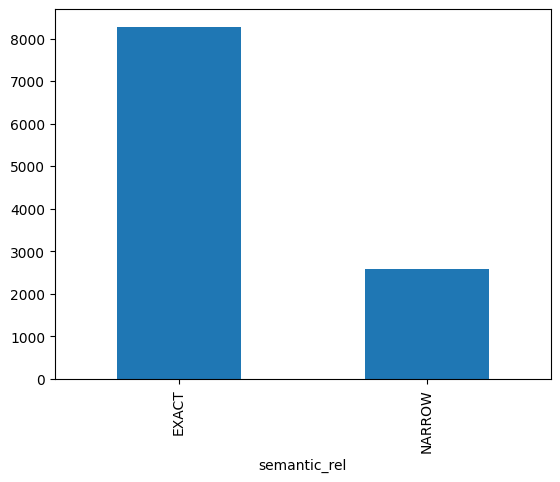

In [15]:
df_symptemist.semantic_rel.value_counts().plot(kind='bar')

## Code overlap

In [16]:
def process_composites(df, df_vars):
    '''
    Function to extract composite codes. Get the first code that is in the list of variables.
    '''

    df_data = df.copy()
    df_vars = df_vars.copy()

    # Get the unique codes from the variables dataframe to process the composites
    ls_var_codes = df_vars["code"].drop_duplicates().tolist()

    # Merge df_variables with df_symptemist on 'code', filling missing values with "NOT_FOUND"
    df_data_comp = df_data[df_data["semantic_rel"] == "COMPOSITE"].copy()
    df_data_comp["code_list"] = df_data_comp["code"].str.split("+")
    df_data_comp["var_code"] = df_data_comp["code_list"].apply(lambda code: [c for c in code if c in ls_var_codes][0] if any(c in ls_var_codes for c in code) else code[0])
    df_data_comp["var_code"] = df_data_comp["var_code"].astype(str)
    df_data_comp.code = df_data_comp.var_code

    # Process composites
    df_data_no_comp = df_data[df_data["semantic_rel"] != "COMPOSITE"].copy()

    # Once composites have a single code instead of a list, concatenate the dataframes
    df_data = pd.concat([df_data_no_comp, df_data_comp], ignore_index=True)

    return df_data

def generate_df_codes(df_data, df_vars):

    # Make copies of the dataframes to avoid modifying the originals
    df_data = df_data.copy()
    df_vars = df_vars.copy()

    df_data = process_composites(df_data, df_vars)

    df_code_ovr = df_vars[["ID", "name", "code", "term", "semantic_tag"]].merge(
                                                                            df_data[['code', 'span', 'semantic_rel']].reset_index(), 
                                                                            on='code', 
                                                                            how='left'
                                                                        ).fillna("NOT_FOUND")

    # assert (df_code_ovr["semantic_rel"] == "COMPOSITE").sum() > 0, "NO COMPOSITES FOUND"

    # Group by 'code', 'span', and 'semantic_rel', then count occurrences
    df_code_ovr = df_code_ovr.groupby(['ID', 'name', 'code', 'span', 'term', 'semantic_rel', 'semantic_tag']).size().reset_index(name='count').sort_values(by="count", ascending=False)

    # Set count to 0 for entries with 'span' marked as "NOT_FOUND"
    df_code_ovr.loc[df_code_ovr.span == "NOT_FOUND", "count"] = 0

    # Rename columns for clarity
    df_code_ovr.columns = ['ID', 'name', 'code', 'span', 'term', 'semantic_rel', 'semantic_tag', 'count']

    
    df_code_ovr["found"] = df_code_ovr["span"] != "NOT_FOUND"

    # Include column of count by code
    df_code_count = df_code_ovr.groupby(["ID"]).aggregate({"count":"sum"}).reset_index()
    df_count_group = df_code_count.groupby("ID").aggregate({"count":"sum"}).reset_index()
    df_code_ovr = df_code_ovr.merge(df_count_group, on="ID", suffixes=('', '_ID'))

    # Include columns of count by semantic_rel
    df_code_rel = df_code_ovr.groupby(["ID", "semantic_rel"]).aggregate({"count":"sum"}).reset_index()
    df_code_rel = df_code_rel.pivot(index="ID", columns="semantic_rel", values="count").fillna(0).reset_index()
    df_code_ovr = df_code_ovr.merge(df_code_rel, on="ID").sort_values(by="count", ascending=False)

    # Print the shape of the resulting dataframe
    print("Shape:", df_code_ovr.shape)
    print("Unique codes:", df_code_ovr["ID"].nunique())
    # Print the number of codes not found (count is 0)
    print("Codes not found:", df_code_ovr[~df_code_ovr["found"]].code.nunique())

    # Print the top 10 codes by count in markdown format
    print(df_code_ovr.head().to_markdown(), "\n")

    # Print the bottom 10 codes by count in markdown format
    print(df_code_ovr.tail().to_markdown(), "\n")

    return df_code_ovr

df_code_ovr = generate_df_codes(df_symptemist, df_variables)

Shape: (728, 13)
Unique codes: 653
Codes not found: 539
|    | ID          | name             |      code | span            | term             | semantic_rel   | semantic_tag   |   count | found   |   count_ID |   EXACT |   NARROW |   NOT_FOUND |
|---:|:------------|:-----------------|----------:|:----------------|:-----------------|:---------------|:---------------|--------:|:--------|-----------:|--------:|---------:|------------:|
|  0 | DT4HSign-19 | weight loss      |  89362005 | pérdida de peso | Weight loss      | EXACT          | finding        |      34 | True    |         64 |      64 |        0 |           0 |
|  1 | DT4HSign-10 | loss of appetite |  79890006 | anorexia        | Loss of appetite | EXACT          | finding        |      30 | True    |         38 |      38 |        0 |           0 |
|  2 | DT4HSign-13 | dizziness        | 404640003 | mareo           | Dizziness        | EXACT          | finding        |      20 | True    |         23 |      23 |        0 |    

<Axes: xlabel='semantic_rel'>

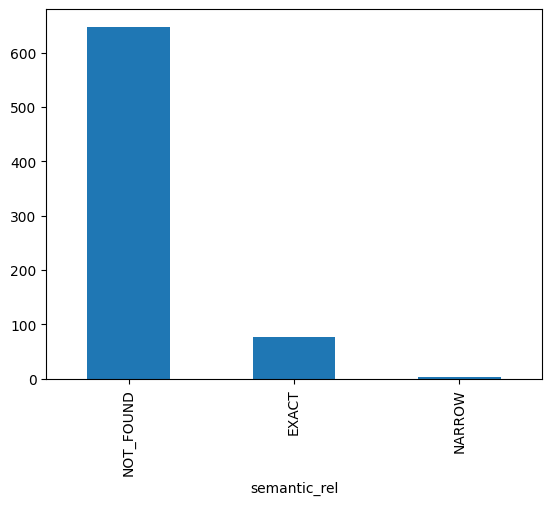

In [17]:
df_code_ovr.semantic_rel.value_counts().plot(kind='bar')

In [18]:
df_code_ovr["ID"].drop_duplicates().shape

(653,)

In [19]:
def plot_code_distribution(df):
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Filter the dataframe to exclude rows where 'span' is "NOT_FOUND"
    df = df.copy()
    ls_semantic_rel = df["semantic_rel"].unique().tolist()

    df["ID+term"] = df["ID"] + "-" + df["name"] + " (" + df["term"] + ")"
    df_found = df.loc[(df["span"] != "NOT_FOUND"), :].copy()
    df_count_rel = df_found[["ID+term"] + ls_semantic_rel + ["count_ID"]].melt(id_vars=["ID+term", "count_ID"], var_name="semantic_rel", value_name="count").drop_duplicates()
    df_n_founds = df[["ID", "found"]].drop_duplicates()

    # Assuming df_found and df_n_founds are already defined

    # Create the pie charts

    fig01 = px.pie(df_n_founds, names='found', title='Found Variables')
    fig01.update_traces(textinfo='label+percent+value')

    fig02 = px.pie(df_found.drop_duplicates(subset=["ID"]), names='semantic_tag', title='Semantic Tag Distribution')
    fig02.update_traces(textinfo='label+percent+value')

    fig03 = px.pie(df_found, names='semantic_rel', title='Semantic Relationship Distribution')
    fig03.update_traces(textinfo='label+percent+value')


    # Create a subplot layout with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Found Variables", "Semantic Tag Distribution", "Semantic Relationship Distribution (Total Mentions)"),
                            specs=[[{"type": "pie"}] * 3])

    # Add the pie charts to the subplots
    fig.add_trace(fig01.data[0], row=1, col=1)
    fig.add_trace(fig02.data[0], row=1, col=2)
    fig.add_trace(fig03.data[0], row=1, col=3)

    # Update the layout to adjust the title and other settings
    fig.update_layout(title_text="Distribution of Semantic Relationships and Found Codes", showlegend=False,
                      height=600)

    # Display the combined figure
    fig.show()

    # print(df_count_rel[df_count_rel.term.str.contains("Diabetes")].to_markdown())
    # Assuming df_aggregated is correctly aggregated data
    n_terms = df_found["ID+term"].nunique()
    n_show = 25

    fig1 = px.bar(df_count_rel.sort_values(by="count_ID", ascending=True),
                y='ID+term', x='count', color='semantic_rel', 
                title=f'Codes by Semantic Relationship [Variable Name (SNOMED term)] <Zoom {n_show} out of {n_terms} terms; zoom out to see all>',
                labels={'count': 'Count', 'ID+term': 'Name'},
                orientation='h')
    
    fig1.update_layout(
                           height=600,
                            yaxis=dict(
                                        range=[n_terms - n_show, n_terms],
                                        tickmode='linear',
                                        dtick=1,
                                    )
                                    )
    fig1.show()

    # Create a bar chart for all the found codes by count
    # ls_IDs = df_found.sort_values(by="count_ID", ascending=False)["ID+term"].unique().tolist()[:25]
    fig2 = px.bar(df_found.sort_values(by="count_ID", ascending=True),
                y='ID+term', x='count', color='span', title=f'Codes Distribution [Variable Name (SNOMED term)] <Zoom {n_show} out of {n_terms} terms; zoom out to see all>',
                labels={'count': 'Count', 'ID+term': 'Name'},
                orientation='h')
    
    fig2.update_layout(showlegend=False, 
                           height=600,
                            yaxis=dict(
                                        range=[n_terms - n_show, n_terms],
                                        tickmode='linear',
                                        dtick=1,
                                    )
                                    )
    fig2.show()


plot_code_distribution(df_code_ovr)